### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

In [22]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

# Data preparation

In [23]:
class DataProperties:
    n_samples = 200
    labeled_percentage = 0.04
    n_dims = 2
    n_clusters = 2

    unlabeled = -1000000  # To mark the unlabelled data instance

In [24]:
from sklearn.datasets import make_blobs
import numpy as np

# Plotting
import matplotlib.pyplot as plt

np.random.seed(numpy_seed)

In [25]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')

Data shape: X: (200, 2), Y: (200,)


## Visualize fully labeled data

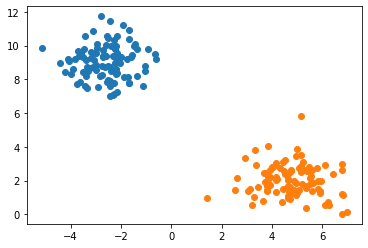

In [26]:
def plot_clusters(Y):
    fig, ax = plt.subplots()

    clusters = np.unique(Y)
    for c in clusters:
        mask = Y == c
        subset = X[mask]
        ax.scatter(
            subset[:, 0],
            subset[:, 1], 
            marker = 'o'
        )


plot_clusters(Y)

## Unlabel subset and visualize

In [27]:
def delabel_data (labeled_data, labeled_percent, delabel_value):
    res = np.ndarray.copy(labeled_data)
    clusters_ids = np.unique(labeled_data)

    for cluster_id in clusters_ids:
        # find indices of object, labeled as cluster_id
        # we keep 'labeled_percent' points still labeled

        cluster_indices = np.where(labeled_data == cluster_id)[0]
        print(f'Found {len(cluster_indices)} instances of object {cluster_id}')

        n_to_delabel = int(len(cluster_indices) * (1 - labeled_percent))
        print(f'We have to delabel {n_to_delabel} instances')

        # we choose data to delabel randomly
        indices_to_delabel = np.random.choice(
            len(cluster_indices - 1),
            n_to_delabel,
            replace = False
        )

        assert len(indices_to_delabel) == n_to_delabel, print(len(indices_to_delabel))
        assert np.max(indices_to_delabel) < len(res)
        assert np.max(indices_to_delabel) <= np.max(cluster_indices)

        res[
            cluster_indices[indices_to_delabel]
        ] = delabel_value
    return res

In [28]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

assert(
    len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]) == int(len(Y) * (1 - DataProperties.labeled_percentage))
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

Found 100 instances of object 0.0
We have to delabel 96 instances
Found 100 instances of object 1.0
We have to delabel 96 instances

    We have 192 unlabeled data
    Out of 200
    


## Visualize data after delabelling

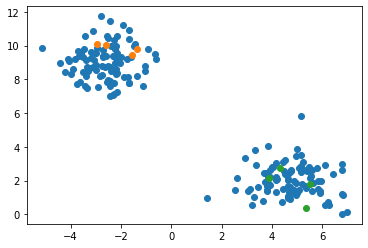

In [29]:
plot_clusters(Y_delabeled)

# Gradient Descent method

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [30]:
import collections
collections.Counter(Y_delabeled)

Counter({-1000000.0: 192, 1.0: 4, 0.0: 4})

In [31]:
def euclidian_similarity(X_i, X_j):
    return np.linalg.norm(X_i - X_j)  # sqrt( sum((x_ii - x_ji)^2) )

class GradientSolver:
    def __init__(
        self, 
        lr_strategy, 
        learning_rate, 
        similarity_func, 
        bcgd_strategy = None
    ):

        available_lr_strategies = [
            'lr_constant'
        ]
        assert lr_strategy in available_lr_strategies, print(f'Pick available lr_strategy: {available_lr_strategies}')

        self.lr_strategy = lr_strategy
        self.learning_rate = learning_rate
        self.similarity_func = similarity_func

        self.losses = []


    def get_learning_rate(self):
        if self.lr_strategy == 'lr_constant':
            return self.learning_rate   

    def compute_grad_component(self, X, Y, labeled_idxs, unlabeled_idxs, idx):

        grad_component = 0.0
            
        for labeled_idx in labeled_idxs:
            w_ij = np.linalg.norm(X[idx] - X[labeled_idx])
            grad_component += 2 * w_ij * (Y[idx] - Y[labeled_idx])

        for another_unlab_idx in unlabeled_idxs:
            w_ij_ = np.linalg.norm(X[idx] - X[another_unlab_idx])
            grad_component += 2 * w_ij_ * (Y[idx] - Y[another_unlab_idx])

        return grad_component

            
    def compute_grad(self, X, Y, labeled_idxs, unlabeled_idxs):

        grad = []
        for unlabeled_idx in unlabeled_idxs:
            # compute component of gradient for this 
            # current unlabeled
            grad_component = self.compute_grad_component(X, Y, labeled_idxs, unlabeled_idxs, idx=unlabeled_idx)
            grad.append(grad_component)

        return np.array(grad)

    def compute_loss(self, X, Y, labeled_idxs, unlabeled_idxs):
        res = 0
        for labeled_idx in labeled_idxs:
            for unlab_idx in unlabeled_idxs:
                w_ij = np.linalg.norm(X[labeled_idx] - X[unlab_idx])
                res += w_ij * ((Y[labeled_idx] - Y[unlab_idx]) ** 2)
        
        for unlab_idx in unlabeled_idxs:
            for another_unlab_idx in unlabeled_idxs:
                w_ij = np.linalg.norm(X[unlab_idx] - X[another_unlab_idx])
                res += 0.5 * w_ij * ((Y[unlab_idx] - Y[another_unlab_idx]) ** 2)
        
        return res

In [32]:
class GradientDescentSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def solve(self, X, Y, iters_limit, delta_loss_limit):

        labeled_idxs = np.where(Y != DataProperties.unlabeled)[0]
        unlabeled_idxs = np.where(Y == DataProperties.unlabeled)[0]

        Y_res = np.ndarray.copy(Y)
        
        # fix initial approximation
        Y_res[Y_res == DataProperties.unlabeled] = 0.5

        loss_prev = 0.0
        self.losses = []
        for i in range(iters_limit):
            loss = self.compute_loss(X, Y_res, labeled_idxs, unlabeled_idxs)
            self.losses.append(loss)
            delta_loss = abs(loss - loss_prev)
            print(f'Loss: {loss}, delta loss: {delta_loss}')


            if (i > 0 and delta_loss < delta_loss_limit):
                return Y_res
            else:
                grad = self.compute_grad(X, Y_res, labeled_idxs, unlabeled_idxs)

                learning_rate = self.get_learning_rate()
                updates = -learning_rate * grad
  
                # print(f'Max update: {np.max(updates)}')

                assert len(unlabeled_idxs) == len(grad)
                for i in range(len(grad)):
                    Y_res[unlabeled_idxs[i]] += updates[i]
                
                loss_prev = loss

        return Y_res

In [33]:
solver = GradientDescentSolver(
    similarity_func = euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.00014
)

In [34]:
Y_preds = solver.solve(
    X,
    Y_delabeled,
    iters_limit = 50,
    delta_loss_limit = 0.0005
)

Loss: 2312.110668607197, delta loss: 2312.110668607197
Loss: 2287.767859586376, delta loss: 24.342809020821278
Loss: 2283.3010725823183, delta loss: 4.466787004057551
Loss: 2282.4505692552175, delta loss: 0.850503327100796
Loss: 2282.2767816063383, delta loss: 0.17378764887916986
Loss: 2282.236710193253, delta loss: 0.04007141308511564
Loss: 2282.2257177320407, delta loss: 0.01099246121248143
Loss: 2282.222016349605, delta loss: 0.003701382435792766
Loss: 2282.2204731322304, delta loss: 0.001543217374546657
Loss: 2282.2196714125785, delta loss: 0.000801719651917665
Loss: 2282.2191545397063, delta loss: 0.0005168728721400839
Loss: 2282.2187568449626, delta loss: 0.0003976947436967748


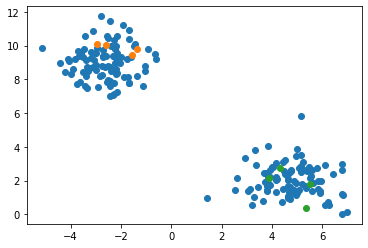

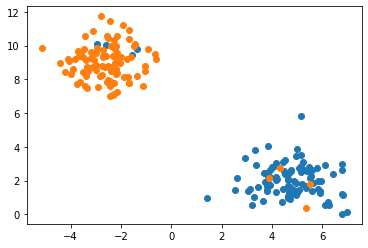

In [35]:
plot_clusters(Y_delabeled)

Y_preds[Y_preds < 0.5] = 0.0
Y_preds[Y_preds >= 0.5] = 1.0
plot_clusters(Y_preds)

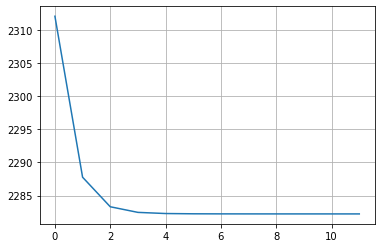

In [36]:
plt.plot(solver.losses)
plt.grid()

# Block coordinates gradient descent (randomized)

In [ ]:
class BCGDSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        available_strategies = [
            # 'cyclic_order',
            'random permutation',
            # 'random sampling'
        ]

        block_strategy = kwargs['block_strategy']
        assert block_strategy in available_strategies, \
            print(f'Please choose available block strategy: {available_strategies}')
        
        self.block_strategy = block_strategy
        # strategies - random permutation & random sampling

    def pick_block_indices(self, unlabeled_indices):
        
        if self.block_strategy == 'random permutation':
            # we just permute the dimensions
            return np.random.permutation(unlabeled_indices)


    def compute_partial_grad(self, X, Y, labeled_idxs, unlabeled_idxs, dimension_index):
        # Return vector of dimension(Y). All zeros,
        # except for derivative on the dimension_index

        pass
            




    def solve(self, X, Y, iter_limit, delta_loss_limit):

        Y_res = np.ndarray.copy(Y)
        labeled_indices = np.where(Y_res != DataProperties.unlabeled)[0]
        unlabeled_indices = np.where(Y_res == DataProperties.unlabeled)[0]
        assert len(labeled_indices) + len(unlabeled_indices) == len(Y_res)

        # Step 1. Choose initial point
        Y_res[unlabeled_indices] = 0.5

        loss_prev = 0
        for i in range(iter_limit):

            loss = self.compute_loss(X, Y_res, labeled_indices, unlabeled_indices)
            delta_loss = abs(loss - loss_prev)

            # Specific condition
            if (i > 0) and delta_loss <= delta_loss_limit:
                return Y_res
            else:
                y = np.ndarray.copy(Y_res)  # y_0
                del Y_res

                # depending on the strategy,
                # S contains one random block, permutation
                # of available coordinates, or same sequence of
                # coordinates (for cyclic approach)
                S = self.pick_block_indices(unlabeled_indices)  # Pick random permutation of unlabeled indices
                print(f'Picked blocks: {S}')
                
                # l = len(S)
                # And now we move across S and update y variable
                for index in S:
                    learning_rate = self.get_learning_rate()
                    # y = y - learning_rate 
                    y = y - learning_rate * self.compute_partial_grad(
                        X,
                        Y,
                        labeled_indices,
                        unlabeled_indices,
                        dimension_index = index
                    )
                Y_res = y
                del y







                # In the task, blocks are of dimension 1 -->
                # blocks of 1-axis coordinate


                Y_res = y